In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from nltk.corpus import stopwords
# from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import re
# from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [81]:
tweet= pd.read_csv('/Users/yankesswang/Downloads/nlp-getting-started/train.csv')
test=pd.read_csv('/Users/yankesswang/Downloads/nlp-getting-started/test.csv')
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [82]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


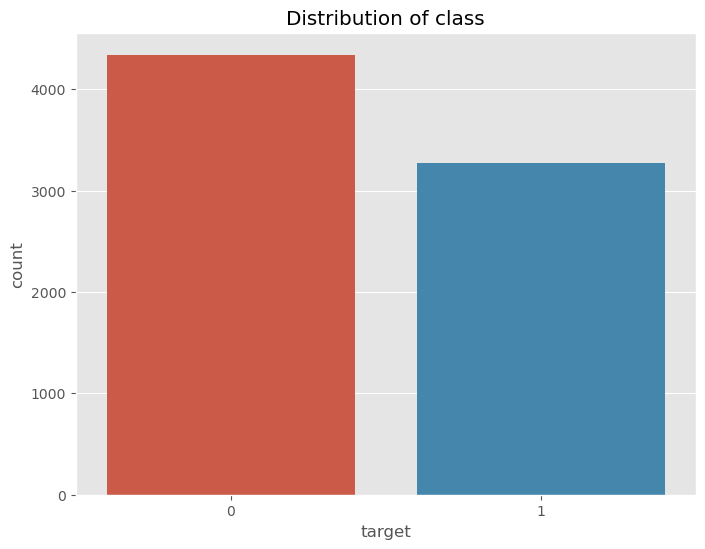

In [83]:
plt.figure(figsize=(8, 6))
sns.countplot(data=tweet, x='target')
plt.title('Distribution of class')
plt.show()

关于 target 列的分布：

类别0（可能代表非目标事件）占比约为57.03%
类别1（可能代表目标事件）占比约为42.97%

In [84]:
basic_stats = tweet.describe(include='all')
basic_stats

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


根据对数据集的基本统计信息：

数据集中总共有7613条记录。
keyword 列有7552个非空值，意味着有一些缺失值。
location 列有5080个非空值，也存在一些缺失值。
数据集中存在221个唯一的 keyword，其中最常见的是 "fatalities"。
数据集中有3341个唯一的 location，其中最常见的是 "USA"。
text 列有7503个唯一值，这意味着存在一些重复的文本。

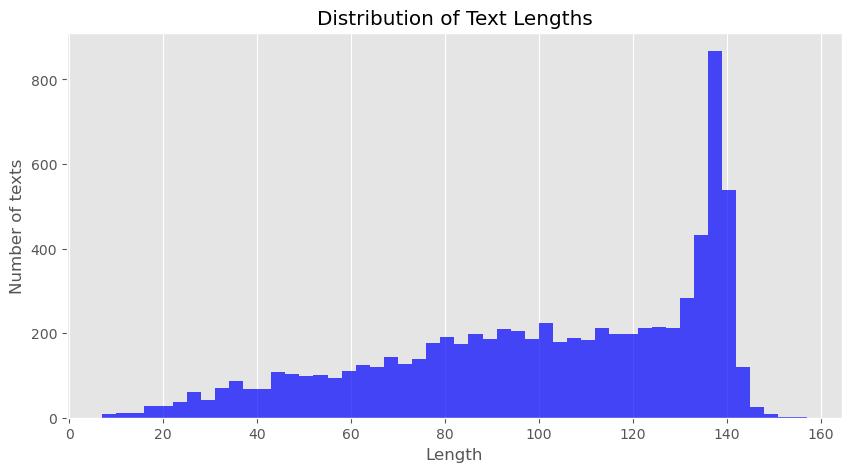

In [85]:
text_lengths = tweet['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Number of texts')
plt.grid(axis='y')

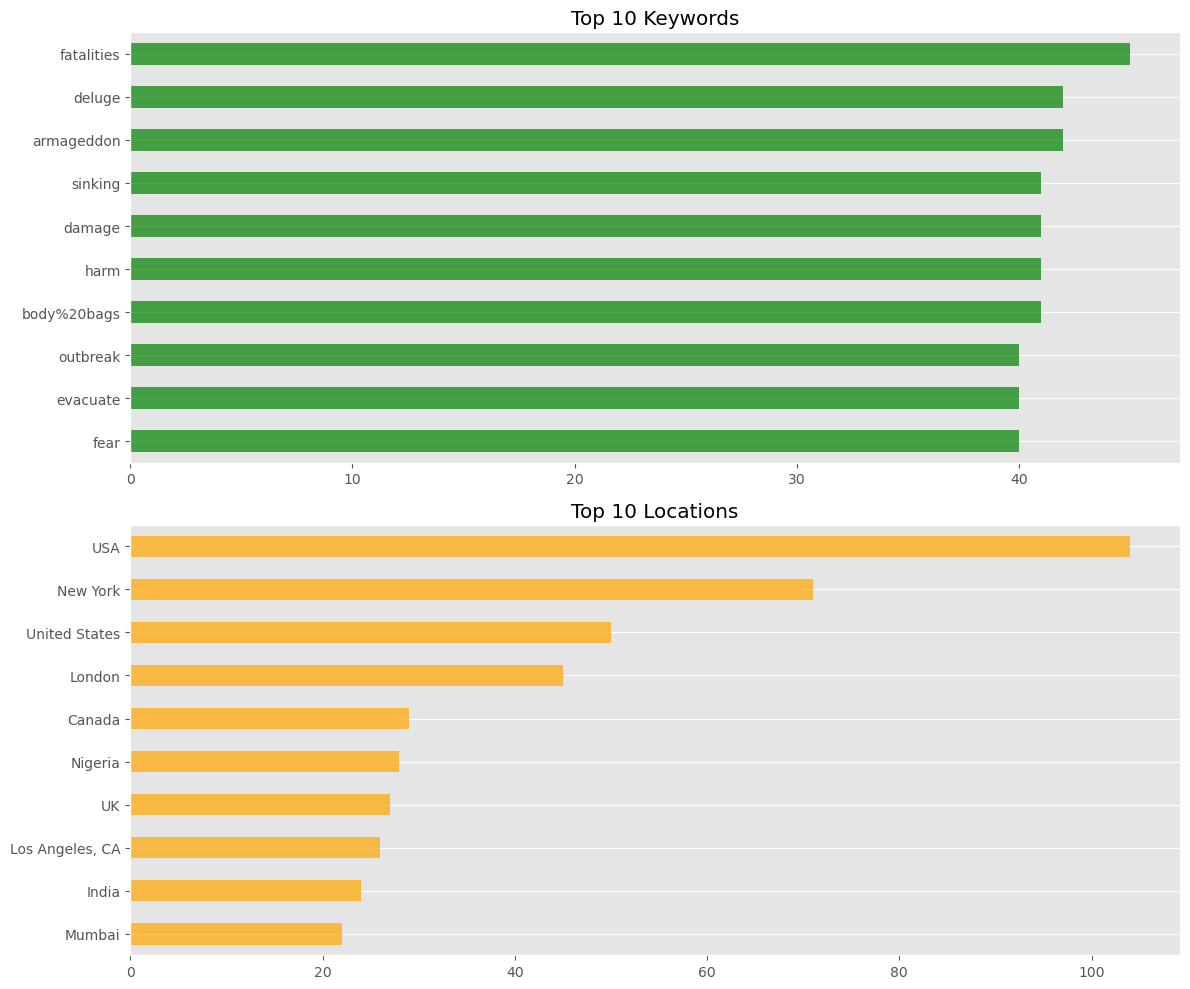

In [86]:
# Getting the top 10 most common keywords and locations
top_keywords = tweet['keyword'].value_counts().head(10)
top_locations = tweet['location'].value_counts().head(10)

# Plotting the top 10 keywords and locations
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

top_keywords.plot(kind='barh', ax=axes[0], color='green', alpha=0.7)
axes[0].set_title('Top 10 Keywords')
axes[0].invert_yaxis()
axes[0].grid(axis='x')

top_locations.plot(kind='barh', ax=axes[1], color='orange', alpha=0.7)
axes[1].set_title('Top 10 Locations')
axes[1].invert_yaxis()
axes[1].grid(axis='x')

plt.tight_layout()
plt.show()


Top 10 Keywords:
"fatalities"、"armageddon"、"harm" 和 "siren" 等是此數據集中最常見的關鍵詞。
Top 10 Locations:
"USA"、"New York"、"United States" 和 "London" 等是最常被提及的地點。

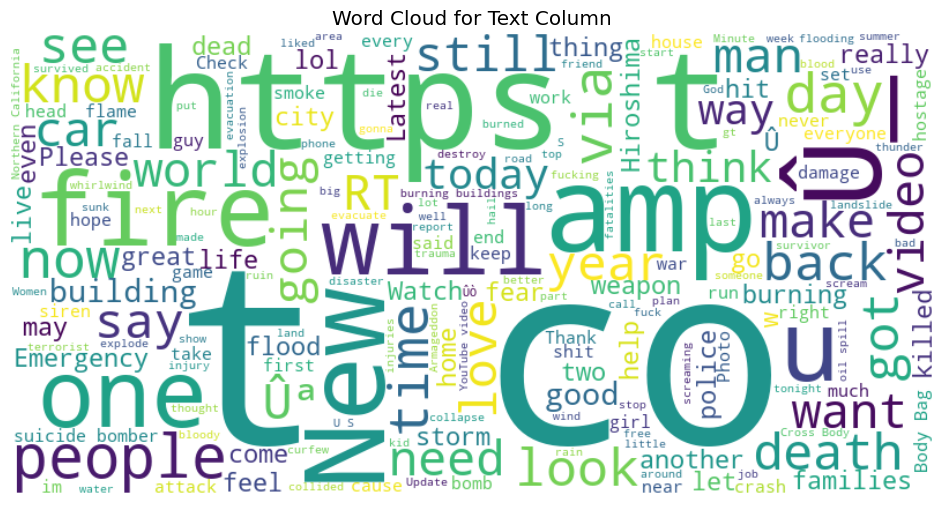

In [87]:
from wordcloud import WordCloud

# Generate a word cloud for the 'text' column
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tweet['text']))

# Plotting the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text Column')
plt.show()

從詞雲中，我們可以看到文本中的一些常見詞語，如 "fire"、"news"、"disaster"、"emergency" 等。這些詞語都與災難和緊急事件相關，與數據集的主題相符。

## 使用 Transformer 進行文本分析

In [88]:
# <!-- 數據預處理 -->
# Tokenization：使用BERT的tokenizer將文本轉換為tokens。
# Attention Masks：建立一個mask來指示哪些tokens是真實的，哪些是填充的。
# Padding：由於BERT需要固定大小的輸入，我們可能需要對較短的句子進行填充。

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 64

input_ids = []
attention_masks = []

for text in tweet['text']:
    text = tokenizer.tokenize(text)[:MAX_LEN-2]  # -2 to account for special tokens
    text = tokenizer.convert_tokens_to_string(text)
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [89]:
# 模型建立
# 使用transformers庫，我們可以輕鬆地加載預訓練的BERT模型。如果您想進行二分類，可以使用BertForSequenceClassification。
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
# 模型訓練
# 首先，我們需要將數據分為訓練集和驗證集。然後，我們將使用 PyTorch 的 DataLoader 來有效地管理批次。

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels= torch.tensor(tweet['target'].values)

train_size= int(0.9* len(input_ids))
val_size= len(input_ids) - train_size
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(tweet, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
batch_size = 32

from torch.utils.data import TensorDataset

# Tokenize and prepare dataset for training set
train_texts = train_df['text'].tolist()
train_labels = torch.tensor(train_df['target'].values)
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)

# Tokenize and prepare dataset for validation set
val_texts = val_df['text'].tolist()
val_labels = torch.tensor(val_df['target'].values)
val_encodings = tokenizer(val_texts, padding=True, truncation=True, return_tensors="pt")
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

# Create DataLoader using the datasets
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size= batch_size 
)

val_dataloader = DataLoader(
    val_dataset,
    sampler= SequentialSampler(val_dataset),
    batch_size= batch_size
)




In [91]:
# 設定優化器和學習率調度器
from transformers import AdamW, get_linear_schedule_with_warmup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr = 2e-5, eps=1e-8)
epochs = 20
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [92]:
# Training
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels)
        total_train_loss += outputs.loss
        outputs.loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")


Average training loss: 0.44154009222984314
Average training loss: 0.3187626004219055
Average training loss: 0.2358035296201706
Average training loss: 0.16720201075077057
Average training loss: 0.11745881289243698
Average training loss: 0.0853237584233284
Average training loss: 0.06525187939405441
Average training loss: 0.04970182105898857
Average training loss: 0.046777982264757156
Average training loss: 0.03796379268169403


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
# Validation

model.eval()
total_eval_accuracy = 0
total_eval_loss = 0
# 這個函數將 logits 和標籤作為輸入，並返回模型的準確率：
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
for batch in val_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels)
    total_eval_loss += outputs.loss
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    total_eval_accuracy += flat_accuracy(logits, label_ids)
avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
print(f"Validation accuracy: {avg_val_accuracy:.2f}")

Validation accuracy: 0.82


In [ ]:
test_data = pd.read_csv("/Users/yankesswang/Downloads/nlp-getting-started/test.csv")
test_input_ids = []
test_attention_masks = []

for tweet in test_data["text"]:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                     
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',     
                   )
    
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

# 3. 使用模型進行預測
model.eval()

predictions = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

# Flatten the predictions list
flat_predictions = [item for sublist in predictions for item in sublist]
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

# 4. 根據需要保存或使用預測結果
test_data['target'] = predicted_labels
test_data.drop(['keyword', 'location', 'text'], axis=1, inplace=True)
test_data.to_csv('/Users/yankesswang/Downloads/nlp_disaster2.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
